In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as prog_bar

In [2]:
save_plot = False

In [3]:
# 1 second
sec = 1/0.01

# 1 minute
mins = sec*60

# 5 minutes
fmin = mins*5

print(f"Our device was set to captured data at 100Hz (max is 200Hz). This resulted in:")
print(f"- {sec} measurements per second")
print(f"- {mins} measurements per minute")
print(f"- {fmin} measurements every 5 minutes")

Our device was set to captured data at 100Hz (max is 200Hz). This resulted in:
- 100.0 measurements per second
- 6000.0 measurements per minute
- 30000.0 measurements every 5 minutes


# Dates dataset

## Create overall dataset

Merge dates dataset with a new dataset that has the number of rows per recording

In [4]:
dates = pd.read_csv('data_formatted/dance_dates.csv', parse_dates=[1])
dates = dates.sort_values('date').reset_index(drop=True)
dates.shape

(35, 3)

In [4]:
# Use combined joints data as template
joints = pd.read_csv('data_formatted/joints.csv')
joints['date'] = pd.to_datetime(joints['date'])
joints.shape

(552507, 15)

In [6]:
joints.head()

,id,date,dance,time,marker,joints-elbow_lt-flexion_(deg),joints-hip_lt-flexion_(deg),joints-hip_lt-abduction_(deg),joints-hip_lt-rotation_ext_(deg),joints-knee_lt-flexion_(deg),joints-elbow_rt-flexion_(deg),joints-hip_rt-flexion_(deg),joints-hip_rt-abduction_(deg),joints-hip_rt-rotation_ext_(deg),joints-knee_rt-flexion_(deg)
0,pddancecon005,2018-11-15 13:47:00,electric slide,0.005,NaN,-0.458238,23.6274,-5.09624,11.6108,10.4402,47.5511,15.5307,2.78938,-8.75014,7.49284
1,pddancecon005,2018-11-15 13:47:00,electric slide,0.015,NaN,-0.448757,23.8983,-5.16222,11.5693,10.9113,47.5581,15.7256,2.73978,-8.65008,7.85280
2,pddancecon005,2018-11-15 13:47:00,electric slide,0.025,NaN,-0.422032,24.1600,-5.23020,11.5772,11.3694,47.5534,15.9043,2.69965,-8.53121,8.19385
3,pddancecon005,2018-11-15 13:47:00,electric slide,0.035,NaN,-0.424552,24.4047,-5.29794,11.6034,11.8062,47.5432,16.0622,2.66440,-8.44873,8.50471
4,pddancecon005,2018-11-15 13:47:00,electric slide,0.045,NaN,-0.429397,24.6267,-5.35555,11.5967,12.2208,47.5337,16.2195,2.63019,-8.36342,8.82541


In [7]:
# Count how many rows per recording
length_calc = joints.groupby(['id','date','dance']).count()['time'].reset_index()
length_calc = length_calc.rename({'time':'row_count'}, axis=1)
length_calc.shape

(35, 4)

Details of the recording settings extracted from raw noraxon excel output:

1. Begin: 0
2. Frequency: 100/s
3. Count: number of rows

So:
* 100 rows = 1 second
* 8029 rows = 80.29 seconds = 80/60 minutes

In [8]:
# Covert to minutes
length_calc['seconds'] = length_calc['row_count'] / 100
length_calc['minutes'] = length_calc['seconds'] / 60

In [9]:
length_calc.head()

,id,date,dance,row_count,seconds,minutes
0,pddance001,2018-07-14 12:20:00,tango - part 1 (easy),8029,80.29,1.338167
1,pddance001,2018-07-14 12:32:00,tango - part 2 (harder),18305,183.05,3.050833
2,pddance002,2018-08-11 11:48:00,rumba1,6076,60.76,1.012667
3,pddance002,2018-08-11 11:55:00,line,6692,66.92,1.115333
4,pddance002,2018-08-11 12:03:00,foxtrot1,6909,69.09,1.151500


In [10]:
dates.head()

,dance,date,id
0,tango - part 1 (easy),2018-07-14 12:20:00,pddance001
1,tango - part 2 (harder),2018-07-14 12:32:00,pddance001
2,rumba1,2018-08-11 11:48:00,pddance002
3,line,2018-08-11 11:55:00,pddance002
4,foxtrot1,2018-08-11 12:03:00,pddance002


In [11]:
# Merge datasets
record_data = dates.merge(length_calc)
record_data.shape

(35, 6)

In [12]:
record_data['group'] = record_data['id'].apply(lambda x: 'control' if 'cecon' in x else 'pd')

In [13]:
record_data['day'] = record_data['date'].apply(lambda x: x.date())

## Categorize dances

In [5]:
def format_dance(my_series):
    '''
    Formats dance names to be machine friendly
    '''
    # make lower case, replace spaces and dashes with _
    new_series = my_series.str.lower().str.replace(' ','_').str.replace('-','').str.replace('__','_')
    # remove numbers
    new_series = new_series.str.replace('_\d','', regex=True).str.replace('\d','', regex=True)
    
    return new_series

In [15]:
record_data['dance_og'] = record_data['dance']
record_data['dance'] = format_dance(record_data['dance'])

Original labels for dance recordings:

In [16]:
record_data.groupby(['dance','group'])[['id']].count().reset_index()

,dance,group,id
0,american_tango,pd,1
1,boxstep,control,1
2,electric_slide,control,2
3,electric_slide,pd,1
4,foxtrot,control,1
5,foxtrot,pd,4
6,line,pd,1
7,line_dance,control,1
8,open_tango,pd,1
9,prominent,control,1


The Smooth category consists of only four dances (omitting American Peabody (the American School equivalent to Quickstep) [Source](https://en.wikipedia.org/wiki/Ballroom_dance):

* American Waltz
* American Tango
* American Foxtrot
* American Viennese Waltz

The Rhythm category are:
* American Cha Cha
* American Rumba
* American East Coast Swing (the American School equivalent to International Jive)
* American Bolero
* American Mambo.

Electric slide is considered a type of line dance: https://en.wikipedia.org/wiki/Line_dance

In [6]:
def cat_dance(text):
    if ('tango' in text) | ('prominent' in text):
        return 'tango'
    elif ('waltz' in text):
        return 'waltz'
    # Dr. Ridgel confirmed boxstep fits with foxtrot
    elif ('foxtrot' in text) | ('boxstep' in text):
        return 'foxtrot'
    # electric slide is a type of line dance
    elif ('electric' in text) | ('line' in text):
        return 'line'
    elif ('swing' in text):
        return 'swing'
    elif 'rumba' in text:
        return 'rumba'
    else:
        return text

In [7]:
def cat_dance_usa(text:str) -> str:
    if ('tango' in text) | ('waltz' in text) | ('foxtrot' in text) | ('line' in text) | ('box' in text):
        return 'smooth'
    elif ('rumba' in text) | ('swing' in text):
        return 'rhythm'

In [19]:
record_data[record_data['dance'].str.contains('rumba')]

,dance,date,id,row_count,seconds,minutes,group,day,dance_og
2,rumba,2018-08-11 11:48:00,pddance002,6076,60.76,1.012667,pd,2018-08-11,rumba1
22,rumba,2018-11-10 12:20:00,pddance005,32556,325.56,5.426000,pd,2018-11-10,rumba2


Only two sessions of rumba, from two participants, both PD. Rumba is removed as it can't be categorized as foxtrot, line, tango, or waltz

In [20]:
# categorize dance
record_data['dance_group'] = record_data['dance'].map(cat_dance)
# remove swing and rumba
record_data = record_data[(record_data['dance_group'] != 'rumba') & (record_data['dance_group'] != 'swing')]

In [21]:
record_data['id'].unique()

array(['pddance001', 'pddance002', 'pddancecon001', 'pddancecon002',
       'pddance003', 'pddancecon003', 'pddancecon004', 'pddance005',
       'pddancecon005', 'pddance006', 'pddance007'], dtype=object)

In [22]:
record_data.to_csv('data_formatted/dance_recordings.csv', index=False)

In [23]:
grp_count = record_data.groupby(['dance_group', 'group']).count()['date'].reset_index()
grp_count = grp_count.rename({'date':'recordings'},axis=1)
grp_count

,dance_group,group,recordings
0,foxtrot,control,2
1,foxtrot,pd,4
2,line,control,3
3,line,pd,2
4,tango,control,4
5,tango,pd,13
6,waltz,control,3
7,waltz,pd,1


In [24]:
subj_count = record_data.groupby(['dance_group', 'id']).count()['date'].reset_index()
subj_count = subj_count.rename({'date':'recordings'},axis=1)
subj_count.sort_values(['dance_group','id'])

,dance_group,id,recordings
0,foxtrot,pddance002,2
1,foxtrot,pddance006,2
2,foxtrot,pddancecon003,2
3,line,pddance002,1
4,line,pddance007,1
5,line,pddancecon001,1
6,line,pddancecon005,2
7,tango,pddance001,2
8,tango,pddance002,3
9,tango,pddance003,2


## Results

In [25]:
record_data.groupby('group').count()

,dance,date,id,row_count,seconds,minutes,day,dance_og,dance_group
group,,,,,,,,,
control,12,12,12,12,12,12,12,12,12
pd,20,20,20,20,20,20,20,20,20


In [26]:
record_data.groupby('id').count()

,dance,date,row_count,seconds,minutes,group,day,dance_og,dance_group
id,,,,,,,,,
pddance001,2,2,2,2,2,2,2,2,2
pddance002,7,7,7,7,7,7,7,7,7
pddance003,2,2,2,2,2,2,2,2,2
pddance005,2,2,2,2,2,2,2,2,2
pddance006,4,4,4,4,4,4,4,4,4
pddance007,3,3,3,3,3,3,3,3,3
pddancecon001,2,2,2,2,2,2,2,2,2
pddancecon002,2,2,2,2,2,2,2,2,2
pddancecon003,3,3,3,3,3,3,3,3,3


### Average length of recording

All datasets are the same length, just different number of variables.

Use joints dataset to find length of dance recordings

In [27]:
rec_means = record_data.groupby(['group','dance_group']).mean().reset_index()
rec_means

,group,dance_group,row_count,seconds,minutes
0,control,foxtrot,19112.000000,191.120000,3.185333
1,control,line,24946.666667,249.466667,4.157778
2,control,tango,21280.000000,212.800000,3.546667
3,control,waltz,17825.333333,178.253333,2.970889
4,pd,foxtrot,10827.500000,108.275000,1.804583
5,pd,line,12158.000000,121.580000,2.026333
6,pd,tango,13670.923077,136.709231,2.278487
7,pd,waltz,6195.000000,61.950000,1.032500


In [28]:
record_data.groupby('group').agg(['mean','std'])['minutes']

,mean,std
group,,
control,3.495278,1.337226
pd,2.096192,1.061126


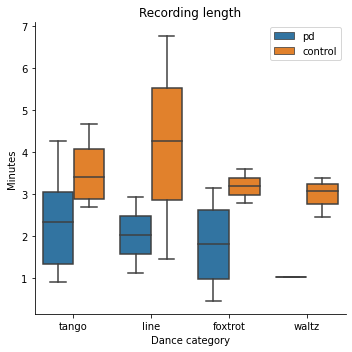

In [29]:
#plt.style.use('figures/paper.mplstyle')
sns.catplot(x='dance_group',y='minutes',data=record_data,kind='box', hue='group', legend = False)
plt.title('Recording length')
plt.xlabel('Dance category')
plt.ylabel('Minutes')
plt.legend(loc='upper right')
plt.tight_layout()

In [31]:
from plotnine import *
import dance_helpers as d # contains function for graph making with plotnine

In [32]:
record_data.columns = [col.title() for col in record_data.columns]
record_data['Dance_Group'] = record_data['Dance_Group'].str.title()
record_data['Group'] = record_data['Group'].str.upper().str.replace('CONTROL','OA')

In [33]:
record_data.head()

,Dance,Date,Id,Row_Count,Seconds,Minutes,Group,Day,Dance_Og,Dance_Group
0,tango_part_(easy),2018-07-14 12:20:00,pddance001,8029,80.29,1.338167,PD,2018-07-14,tango - part 1 (easy),Tango
1,tango_part_(harder),2018-07-14 12:32:00,pddance001,18305,183.05,3.050833,PD,2018-07-14,tango - part 2 (harder),Tango
3,line,2018-08-11 11:55:00,pddance002,6692,66.92,1.115333,PD,2018-08-11,line,Line
4,foxtrot,2018-08-11 12:03:00,pddance002,6909,69.09,1.151500,PD,2018-08-11,foxtrot1,Foxtrot
5,foxtrot,2018-08-11 12:08:00,pddance002,2821,28.21,0.470167,PD,2018-08-11,foxtrot2,Foxtrot


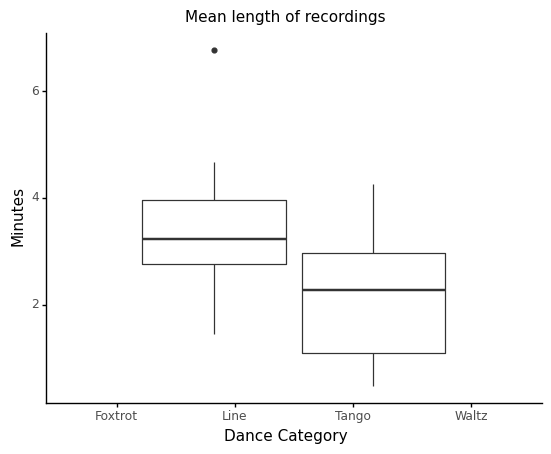

<ggplot: (8774021335083)>

In [34]:
p = (
    ggplot(record_data, aes(x='Dance_Group',y='Minutes', group='Group')) +
    geom_boxplot() +
    ggtitle("Mean length of recordings") +
    xlab('Dance Category') +
    ylab('Minutes') +
    d.pub_theme(11)
)
p 

### Number of recordings per dance

In [39]:
from dance_helpers import pub_theme

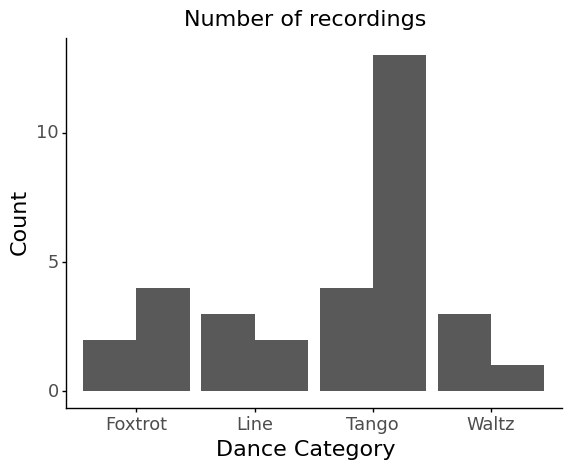

<ggplot: (8774021263818)>

In [40]:
q = (
    ggplot(record_data, aes(x='Dance_Group', group='Group')) +
    geom_bar(position = 'dodge') +
    ggtitle("Number of recordings") +
    xlab("Dance Category") +
    ylab("Count") +
    pub_theme(16)
 
)
q

### Number of participants per dance

In [43]:
record_data.columns = [col.lower() for col in record_data.columns]

In [44]:
parts = record_data.groupby(['dance_group','id']).count()['dance'].reset_index()
parts = parts.rename({'id':'recordings'}, axis=1)
parts

,dance_group,recordings,dance
0,Foxtrot,pddance002,2
1,Foxtrot,pddance006,2
2,Foxtrot,pddancecon003,2
3,Line,pddance002,1
4,Line,pddance007,1
5,Line,pddancecon001,1
6,Line,pddancecon005,2
7,Tango,pddance001,2
8,Tango,pddance002,3
9,Tango,pddance003,2


### Number of recordings per participant and day

In [45]:
record_data.groupby(['id','day']).count()

,,dance,date,row_count,seconds,minutes,group,dance_og,dance_group
id,day,,,,,,,,
pddance001,2018-07-14,2,2,2,2,2,2,2,2
pddance002,2018-08-11,7,7,7,7,7,7,7,7
pddance003,2018-10-13,2,2,2,2,2,2,2,2
pddance005,2018-11-10,2,2,2,2,2,2,2,2
pddance006,2018-12-08,4,4,4,4,4,4,4,4
pddance007,2019-09-14,3,3,3,3,3,3,3,3
pddancecon001,2018-10-11,2,2,2,2,2,2,2,2
pddancecon002,2018-10-11,2,2,2,2,2,2,2,2
pddancecon003,2018-10-18,3,3,3,3,3,3,3,3


In [46]:
sessions = record_data.groupby(['id', 'dance_group'])['dance'].count().reset_index()

In [47]:
sessions = sessions.rename({'dance':'recordings'}, axis = 1)
sessions['group'] = sessions['id'].apply(lambda x: 'control' if 'cecon' in x else 'pd')
sessions.head()

,id,dance_group,recordings,group
0,pddance001,Tango,2,pd
1,pddance002,Foxtrot,2,pd
2,pddance002,Line,1,pd
3,pddance002,Tango,3,pd
4,pddance002,Waltz,1,pd


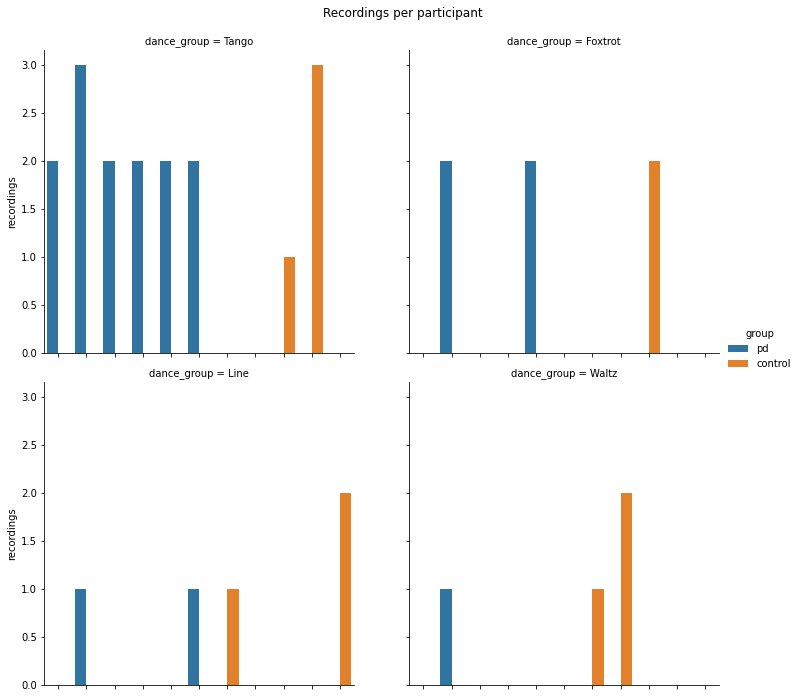

In [49]:
g=sns.catplot(x='id', y='recordings', data=sessions, col = 'dance_group', hue='group', col_wrap=2, kind='bar')
g.set(xticklabels=[],xlabel='')
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('')
g.fig.suptitle('Recordings per participant')
g.fig.subplots_adjust(top=0.92)

# Demographics

Filling in the blanks:

> Here’s what I have.  You can calculate BMI from these numbers.
> 
> Pddancecon002-age 75
>
> Pddancecon003-age 71
>
> Pddancecon005- Height 5’4, weight 140
> 
> PDdance001- Not listed
> 
> PDdance003- age 66
> 
> Pdance005- Height 5’11, weight 200
> 
> Pdance006- Height 5’9, weight 166
> 
> Pdance007- Height 5’8, weight 147

In [8]:
missing_age_map = {
    'pddancecon002':75,
    'pddancecon003':71,
    'pddance003':66}

missing_stats_map = {
    'pddancecon005':[64, 140],
    'pddance005':[71, 200],
    'pddance006':[69, 166],
    'pddance007':[68, 147]
}

In [9]:
demos = pd.read_spss('Data/SPSS/DanceStudy_PrePost.sav')
demos['ID'] = demos['ID'].str.replace('PD','PDDANCE').str.replace('CON','PDDANCECON')

In [10]:
import glob
files = glob.glob("Data/noraxon/*/*.csv")
files = pd.Series(files)
files = files[files.str.contains("info.csv")].reset_index(drop=True)

In [11]:
info = pd.DataFrame()
for file in prog_bar(files):
    temp = pd.read_csv(file)
    info = info.append(temp)

  0%|          | 0/11 [00:00<?, ?it/s]

In [12]:
demos = demos.merge(info, left_on = 'ID', right_on = 'last_name',how = 'right')

In [13]:
all_parts = list(record_data['id'].unique())
all_parts.sort()
all_parts

NameError: name 'record_data' is not defined

In [14]:
demos.sample(2)

,ID,Group,Pre_MDGI,Post_MDGI,Pre_9HPT_L,Post_9HPT_L,Pre_9HPT_R,Post_9HPT_R,Pre_FES,Post_FES,...,Heightin,Weightlbs,filter_$,type,exported_with_version,project,last_name,first_name,born,sex
7,PDDANCE001,PD,61.0,63.0,23.60,21.60,20.46,20.83,20.0,NaN,...,73.0,NaN,Not Selected,subject,3.12.70,PD Dance Study,PDDANCE001,PDDANCE001,NaN,male
3,PDDANCE002,PD,49.0,54.0,39.69,32.41,31.59,29.04,20.0,17.0,...,73.0,245.0,Not Selected,subject,3.12.70,PD Dance Study,PDDANCE002,PDDANCE002,1951-01-01,male


In [15]:
cols = ['last_name', 'Heightin', 'Weightlbs','born','sex']
demos = demos[cols]
demos.columns = [col.lower() for col in cols]
demos['last_name'] = demos['last_name'].str.lower()

In [16]:
demos['born'] = demos['born'].str.extract('(\d\d\d\d)-').astype(float)

In [17]:
demos = demos.rename({'last_name':'id'}, axis = 1)

In [18]:
# 'All recordings were done in 2018 except for pddance007, it was done in 2019'
age_map = {}
for i, row in prog_bar(demos.iterrows()):
    if row['id'] != 'pddance007':
        age = 2018 - row['born']
    else:
        age = 2019 - row['born']
    age_map[row['id']] = age

0it [00:00, ?it/s]

In [19]:
demos['age'] = demos['id'].map(age_map)

In [20]:
demos = demos.set_index('id')
# insert missing age
for key in missing_age_map.keys():
    part = key
    age = missing_age_map[part]
    
    demos.loc[part, 'age'] = age
    
# insert missing height/weight
for key in missing_stats_map.keys():
    part = key
    height = missing_stats_map[part][0]
    weight = missing_stats_map[part][1]
    
    demos.loc[part, 'heightin'] = height
    demos.loc[part, 'weightlbs'] = weight

demos = demos.reset_index()

weight in pounds (lb) by height in inches (in) squared and multiplying by a conversion factor of 703. 

In [21]:
demos['group'] = demos['id'].apply(lambda x: 'control' if 'cecon' in x else 'pd')
demos['bmi'] = round((demos['weightlbs'] / (demos['heightin']**2)) * 703,1)
demos = demos[['id','group','sex','age','bmi','heightin','weightlbs']].sort_values(['group','id']).reset_index(drop=True)

In [22]:
demos.groupby(['group','sex']).count()

id  age  bmi  heightin  weightlbs
group   sex                                      
control female   3    3    3         3          3
        male     2    2    2         2          2
pd      male     6    5    5         6          5

In [23]:
demos.groupby('group').agg(['mean','std'])

age              bmi           heightin           weightlbs  \
         mean       std   mean       std     mean       std      mean   
group                                                                   
control  73.0  4.636809  25.34  4.392380     63.8  3.962323     145.2   
pd       69.0  7.483315  26.42  3.846037     71.0  2.097618     188.6   

                    
               std  
group               
control  15.658863  
pd       37.300134

In [67]:
demos.to_csv('data_formatted/demos_merged.csv', index=False)

# Joints

In [29]:
joints = pd.read_csv('data_formatted/joints.csv')

In [2]:
def format_dance(my_series):
    '''
    Formats dance names to be machine friendly
    '''
    # make lower case, replace spaces and dashes with _
    new_series = my_series.str.lower().str.replace(' ','_').str.replace('-','').str.replace('__','_')
    # remove numbers
    new_series = new_series.str.replace('_\d','', regex=True).str.replace('\d','', regex=True)
    
    return new_series

In [6]:
def cat_dance(text):
    if ('tango' in text) | ('prominent' in text):
        return 'tango'
    elif ('waltz' in text):
        return 'waltz'
    # Dr. Ridgel confirmed boxstep fits with foxtrot
    elif ('foxtrot' in text) | ('boxstep' in text):
        return 'foxtrot'
    # electric slide is a type of line dance
    elif ('electric' in text) | ('line' in text):
        return 'line'
    elif ('swing' in text):
        return 'swing'
    elif 'rumba' in text:
        return 'rumba'
    else:
        return text

In [7]:
# Create unique ID
joints['unique_id'] = joints['id'] + '_' + joints['date'] + '_' + joints['dance']
unique_id = list(joints['unique_id'].unique())
part = list(joints['id'].unique())

unique_id.sort()
part.sort()

# Rename IDs
new_id_map = {}
for p in part:
    sess_counter = 0
    for u in unique_id:
        if p in u:
            sess_counter += 1
            if sess_counter < 10:
                new_id_map[u] = f"{p}_record0{sess_counter}"
            else:
                new_id_map[u] = f"{p}_record1{sess_counter}"

In [8]:
joints['dance_group'] = joints['dance'].apply(cat_dance)
joints['group'] = joints['id'].apply(lambda x: 'control' if 'cecon' in x else 'pd')

In [9]:
def test_unique_id(dataframe):
    '''
    Tests that each participant has appropriate number of sessions
    '''
    answer = {
        'pddance001':2,
        'pddance002':8,
        'pddance003':2,
        'pddance005':3,
        'pddance006':4,
        'pddance007':4,
        'pddancecon001':2,
        'pddancecon002':2,
        'pddancecon003':3,
        'pddancecon004':3,
        'pddancecon005':2
    }
    
    id_test = dataframe.groupby('unique_id').count().reset_index()['unique_id'].str.split('_', expand=True)
    id_test.columns = ['id','record']
    res = id_test.groupby('id').count().reset_index()
    
    counter = 0
    for i, row in res.iterrows():
        if row['record'] == answer[row['id']]:
            counter +=1
    if counter == len(answer.keys()):
        return 'PASSED'
    else:
        return 'FAILED', res, counter

In [ ]:
joints['unique_id'] = joints['unique_id'].map(new_id_map)
joints['record'] = joints['unique_id'].apply(lambda x: x.split('_')[1])
joints = joints.drop(['marker'], axis=1)

In [ ]:
unique_id = joints.unique_id.unique()

In [ ]:
test_unique_id(joints)

In [38]:
j_id = list(joints['id'].unique())
j_id.sort()
j_id

['pddance001',
 'pddance002',
 'pddance003',
 'pddance005',
 'pddance006',
 'pddance007',
 'pddancecon001',
 'pddancecon002',
 'pddancecon003',
 'pddancecon004',
 'pddancecon005']

In [ ]:
joints.to_csv('data_formatted/joints.csv', index=False)

# Segments

In [ ]:
segments = pd.read_csv('data_formatted/segments.csv')

In [ ]:
segments['dance'] = format_dance(segments['dance'])
segments['dance'] = segments['dance'].apply(cat_dance)
segments['group'] = segments['id'].apply(lambda x: 'control' if 'con' in x else 'pd')

In [ ]:
segments = segments.astype({
    'date':'datetime64',
})

In [ ]:
# rename columns
new_cols = [col.replace('segments-','') for col in segments.columns]
segments.columns = new_cols

In [ ]:
segments.info()

In [ ]:
segments.to_csv('data_formatted/segments_proccessed.csv', index=False)

In [79]:
base_cols = ['id','dance','time','date','marker','group']
body_cols = [col for col in segments.head() if col not in base_cols]

In [80]:
def get_z():
    '''
    Saved for posterity. Used to get z values for all 100+ columns
    '''
    z_segments = {}

    for col in segments.columns:
        if segments[col].dtype == float:
            z_col = (segments[col] - segments[col].mean()) / segments[col].std()
            z_segments[f'z_{col}'] = z_col


    z_seg = pd.DataFrame(z_segments).drop('z_time',axis=1)

    z_seg = pd.concat([segments[base_cols], z_seg], axis=1)
    z_seg.to_csv('data_formatted/z_segments.csv', index = False)

## Acceleration x-axis

In [82]:
tango = segments[segments['dance'] == 'tango']

In [83]:
# extract relevant columns
base_cols = ['id','group','date','dance','time','marker']
seg_x = base_cols + [col for col in tango.columns if ('acceleration' in col) & ('-x_(mg)' in col)]
# select relevant columns
tango_segx = tango[seg_x]

# melt df for graphing
tango_segx_melt = tango_segx.melt(id_vars = base_cols)

In [84]:
cols_split = tango_segx_melt['variable'].str.split('-', expand=True)
cols_split.columns = ['body','measure','axis']
tango_melt_sep = pd.concat([tango_segx_melt, cols_split], axis = 1)

In [85]:
bodies = list(tango_melt_sep['body'].unique())
bodies.sort()

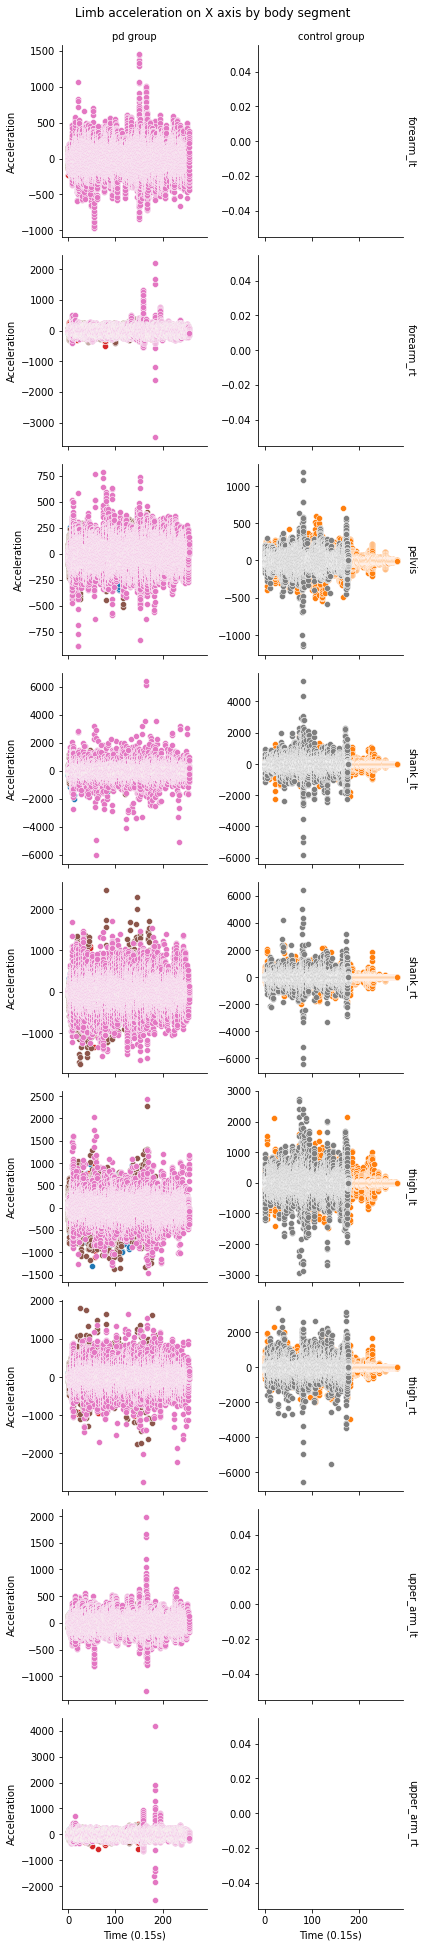

In [86]:
g = sns.FacetGrid(tango_melt_sep, row = 'body', col = 'group', hue='id', sharey = False,
                  margin_titles=True,
                  row_order = bodies)
g.map(sns.scatterplot, 'time', 'value')
g.set_axis_labels(x_var = 'Time (0.15s)', y_var = 'Acceleration')
g.set_titles(col_template="{col_name} group", row_template="{row_name}")
g.fig.suptitle("Limb acceleration on X axis by body segment", y = 1.0)
g.fig.subplots_adjust(top=0.98)
if save_plot:
    g.savefig('figures/facet_ax.png',dpi=300)

In [87]:
pd5 = tango_melt_sep[(tango_melt_sep['id'] == 'pddance005') &
                     (tango_melt_sep['variable'] == 'pelvis-acceleration-x_(mg)')]

### Stats

In [88]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(pd5.value.dropna().values, autolag='AIC',)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(pd5.value.dropna().values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -27.24676966562008
p-value: 0.0
Critial Values:
   1%, -3.4305514544914626
Critial Values:
   5%, -2.8616290376879343
Critial Values:
   10%, -2.5668173920010253

KPSS Statistic: 0.005118
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.



The time series is stationary because nulls are rejected:

* ADF Test null: time series possesses a unit root and is non stationary. Reject if p < 0.05
* KPSS Test null: time series does not possess a unit root and is stationary. Reject if p > 0.05

<AxesSubplot:xlabel='time', ylabel='value'>

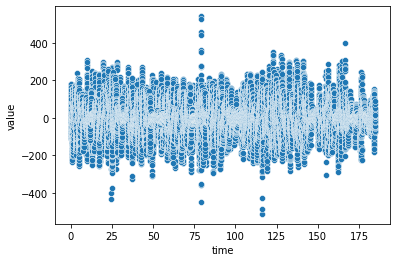

In [89]:
sns.scatterplot(x='time', y= 'value', data = pd5)

Looks like white noise

In [90]:
pd5['value'].describe()

count    32512.000000
mean         0.162678
std         81.018740
min       -512.163000
25%        -44.488475
50%         -0.094656
75%         43.693100
max        541.962000
Name: value, dtype: float64

In [91]:
from scipy import signal

In [92]:
# around 100 values were missing. These were forward filled.
pd5.value.isna().sum()

0

In [93]:
pd5['value'] = pd5['value'].fillna(method='ffill')

<ipython-input-93-330b5370bb5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [94]:
pd5['detrend'] = signal.detrend(pd5.value.values)

<ipython-input-94-d52bb7122237>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:xlabel='time', ylabel='detrend'>

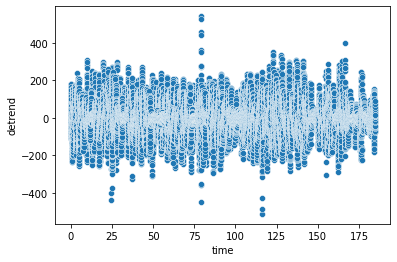

In [95]:
sns.scatterplot(x='time',y='detrend',data=pd5)

#### Plot autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

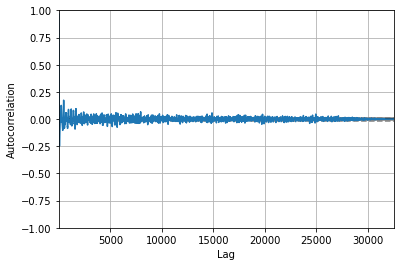

In [96]:
import matplotlib.pyplot as plt

# change size of graphs
# plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
pd.plotting.autocorrelation_plot(pd5.value.tolist())

Lag plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

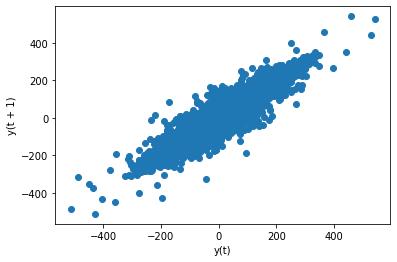

In [97]:
pd.plotting.lag_plot(pd5['value'])

#### Autocorrelations

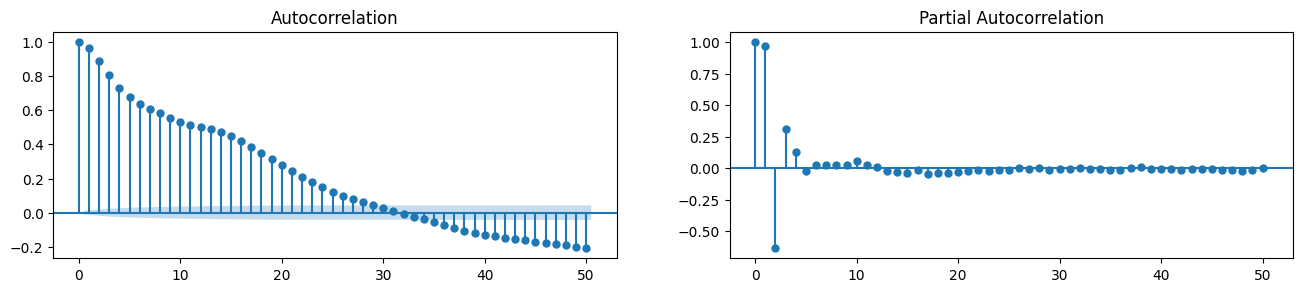

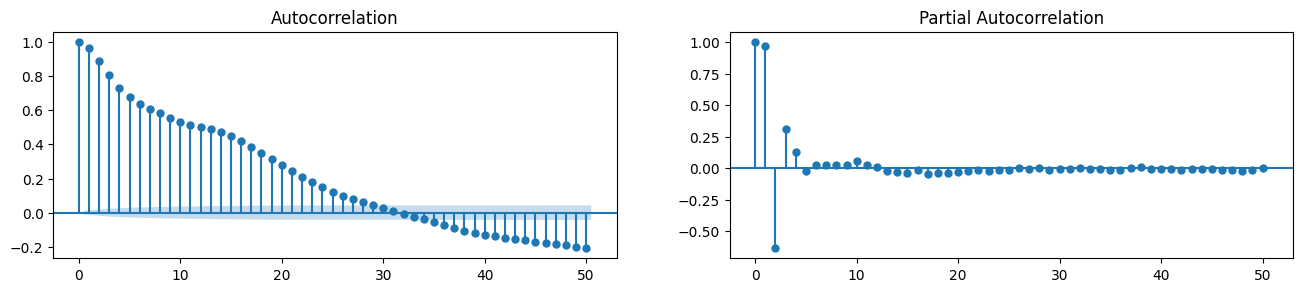

In [98]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd5

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1])

### Modeling

#### Persistance Model

Establish basetime performance. Persistance model is used to predict the last X numbers of the series.
* Training set: everything up the the last X observations
* Test set: just the last X observations

[Source](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/)

In [99]:
last_x = int(1/0.01) # every 1 seconds

In [100]:
train = pd5.iloc[0:len(pd5)-last_x]
test = pd5.iloc[len(pd5)-last_x:]

<AxesSubplot:xlabel='time', ylabel='value'>

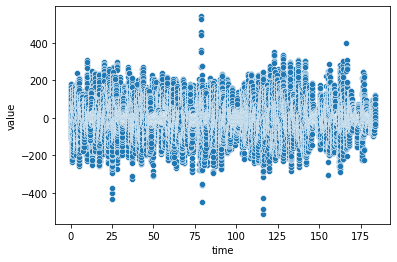

In [101]:
sns.scatterplot(data = train, x='time',y='value')

<AxesSubplot:xlabel='time', ylabel='value'>

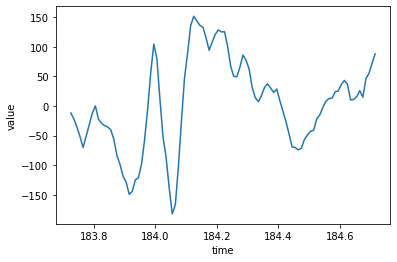

In [102]:
sns.lineplot(data = test, x='time',y='value')

Test MSE: 636.359


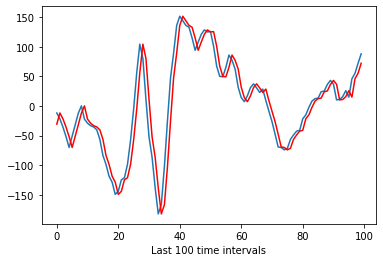

In [103]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
series = pd5['value']
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-last_x], X[len(X)-last_x:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
	return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.xlabel(f'Last {last_x} time intervals')
pyplot.show()

#### Autoregression modeling

Coefficients: [ 5.84155968e-03  1.72282027e+00 -9.61492673e-01  4.63087721e-02
  1.86278050e-01 -4.30747244e-02 -3.36003012e-03  1.56877110e-03
  3.15604891e-02 -4.34841638e-02  2.28173059e-02 -3.41912009e-03
  2.54469575e-02 -1.45227236e-03  2.62776188e-02 -4.36441163e-02
  3.10293293e-02 -1.39921016e-02  9.07175367e-03 -1.00217894e-02
  1.89877477e-03 -1.40611206e-02  3.79113968e-03 -5.25692375e-03
  9.20430300e-03 -2.01628125e-02  1.88046794e-02 -2.73006890e-02
  2.34865579e-02 -1.18707790e-02]
Test RMSE: 71.363


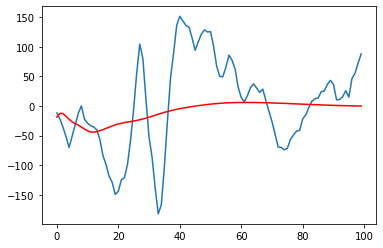

In [104]:
# create and evaluate a static autoregressive model
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# split dataset
X = series.values
train, test = X[1:len(X)-last_x], X[len(X)-last_x:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
# 	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Test RMSE: 16.007


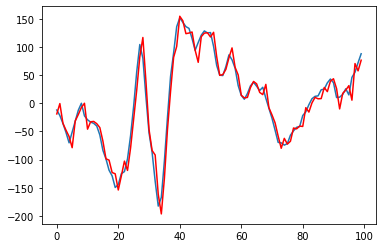

In [105]:
X = series.values
train, test = X[1:len(X)-last_x], X[len(X)-last_x:]
# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## Acceleration y-axis

In [106]:
# extract relevant columns
base_cols = ['id','group','date','dance','time','marker']
seg_y = base_cols + [col for col in tango.columns if ('acceleration' in col) & ('-y_(mg)' in col)]
# select relevant columns
tango_segy = tango[seg_y]

# melt df for graphing
tango_segy_melt = tango_segy.melt(id_vars = base_cols)

In [107]:
cols_split = tango_segy_melt['variable'].str.split('-', expand=True)
cols_split.columns = ['body','measure','axis']
tango_melt_sep = pd.concat([tango_segy_melt, cols_split], axis = 1)

In [108]:
bodies = list(tango_melt_sep['body'].unique())
bodies.sort()

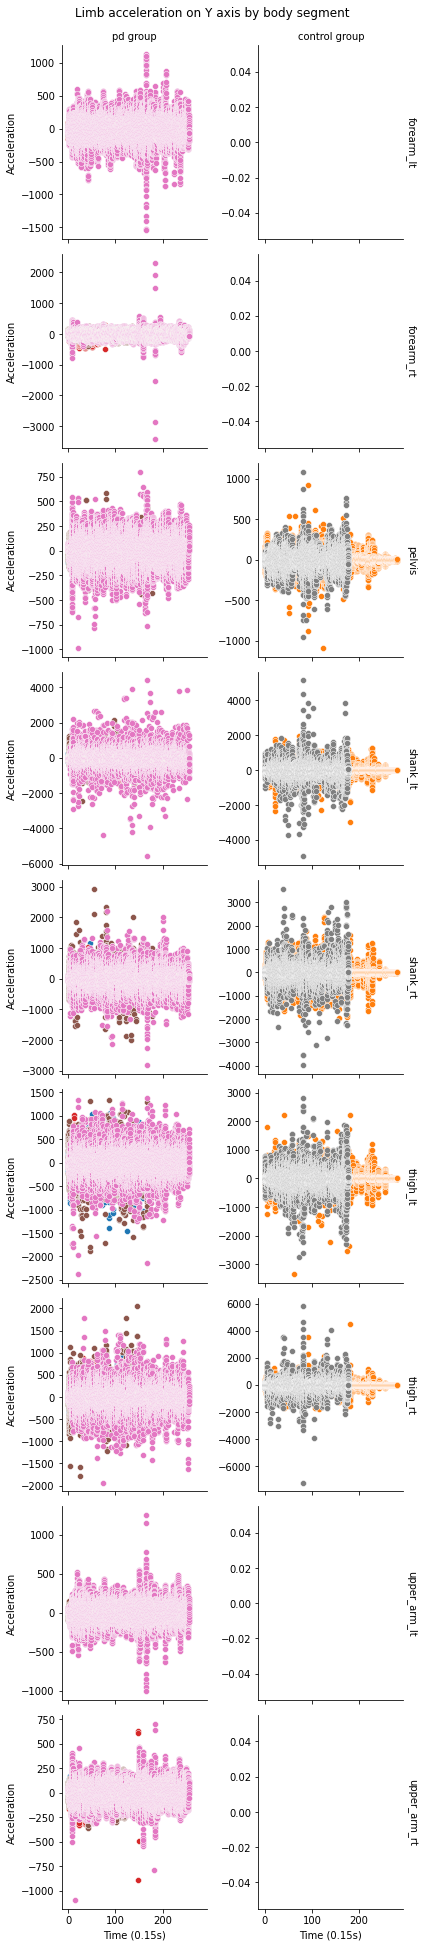

In [109]:
g = sns.FacetGrid(tango_melt_sep, row = 'body', col = 'group', hue='id', sharey = False,
                  margin_titles=True,
                  row_order = bodies)
g.map(sns.scatterplot, 'time', 'value')
g.set_axis_labels(x_var = 'Time (0.15s)', y_var = 'Acceleration')
g.set_titles(col_template="{col_name} group", row_template="{row_name}")
g.fig.suptitle("Limb acceleration on Y axis by body segment", y = 1.0)
g.fig.subplots_adjust(top=0.98)
if save_plot:
    g.savefig('figures/facet_ay.png',dpi=300)

## Acceleration z-axis

In [110]:
# extract relevant columns
base_cols = ['id','group','date','dance','time','marker']
seg_z = base_cols + [col for col in tango.columns if ('acceleration' in col) & ('-z_(mg)' in col)]
# select relevant columns
tango_segz = tango[seg_z]

# melt df for graphing
tango_segz_melt = tango_segz.melt(id_vars = base_cols)

In [111]:
cols_split = tango_segz_melt['variable'].str.split('-', expand=True)
cols_split.columns = ['body','measure','axis']
tango_melt_sep = pd.concat([tango_segz_melt, cols_split], axis = 1)

In [112]:
bodies = list(tango_melt_sep['body'].unique())
bodies.sort()

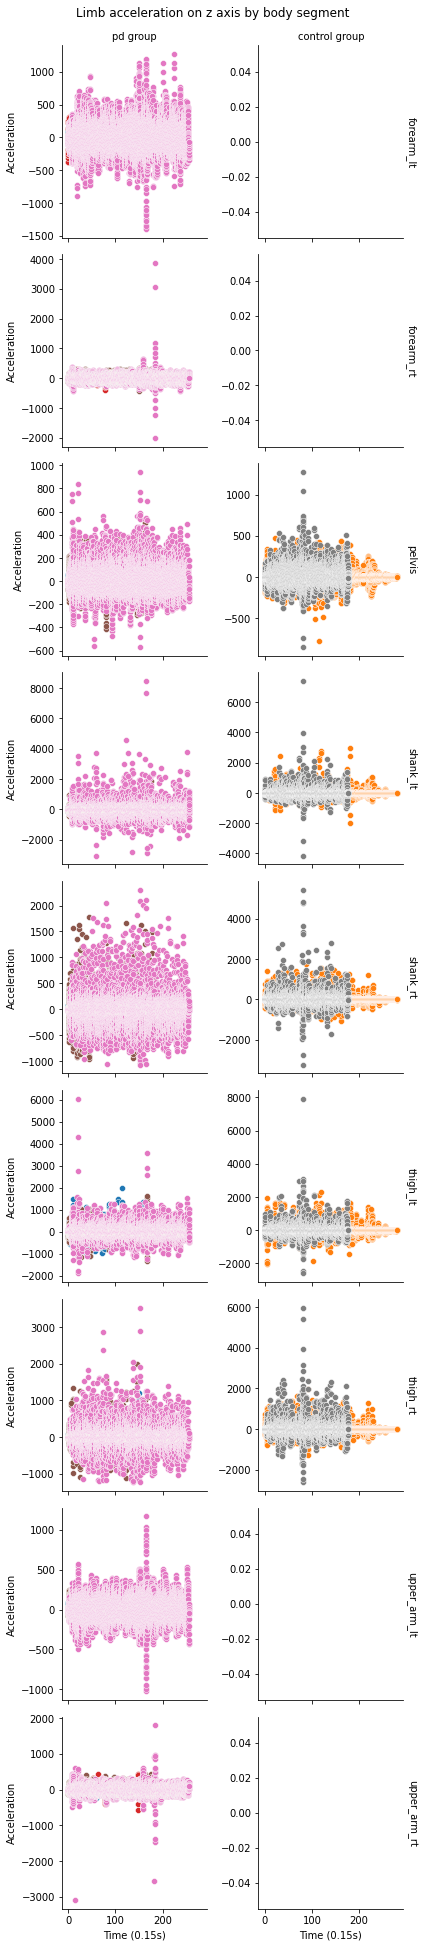

In [113]:
g = sns.FacetGrid(tango_melt_sep, row = 'body', col = 'group', hue='id', sharey = False,
                  margin_titles=True,
                  row_order = bodies)
g.map(sns.scatterplot, 'time', 'value')
g.set_axis_labels(x_var = 'Time (0.15s)', y_var = 'Acceleration')
g.set_titles(col_template="{col_name} group", row_template="{row_name}")
g.fig.suptitle("Limb acceleration on z axis by body segment", y = 1.0)
g.fig.subplots_adjust(top=0.98)
if save_plot:
    g.savefig('figures/facet_az.png',dpi=300)

## Total Acceleration

In [114]:
def total_accel(x: pd.Series,y: pd.Series, z:pd.Series) -> pd.Series:
    '''
    Calculates the total acceleration from x,y,z coordinates
    '''
    
    a_1 = x**2 + y**2 + z**2
    a = a_1.apply(sqrt)
    
    return a

In [115]:
seg_accel = segments[['id','date','dance','time','marker','group'] + [col for col in segments.columns if 'acceleration' in col]]

In [120]:
seg_accel['pelvis_total_accel'] = total_accel(seg_accel['pelvis-acceleration-x_(mg)'],
                                              seg_accel['pelvis-acceleration-y_(mg)'],
                                              seg_accel['pelvis-acceleration-z_(mg)'])

<ipython-input-120-3d68b59172bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [121]:
pd5_wide = seg_accel[(seg_accel['dance'] == 'tango') & (seg_accel['id'] == 'pddance005')]

<AxesSubplot:xlabel='time', ylabel='pelvis_total_accel'>

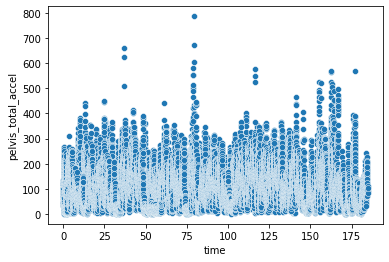

In [122]:
sns.scatterplot(data = pd5_wide, x = 'time', y = 'pelvis_total_accel')

<AxesSubplot:xlabel='time', ylabel='pelvis-acceleration-x_(mg)'>

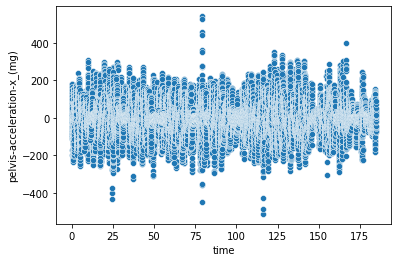

In [123]:
sns.scatterplot(x='time',y='pelvis-acceleration-x_(mg)', data = pd5_wide)

# Entropy of Movement

In [124]:
samen = pd.read_csv('Data/analyze_samen.csv')

In [125]:
clean = pd.read_csv('Data/clean_samen.csv')

In [126]:
clean_melt = clean.melt(id_vars = ['Date','Participant','Group','Dance_Type'])

In [127]:
clean_melt.head()

,Date,Participant,Group,Dance_Type,variable,value
0,2018-07-14T12:20:00Z,pddance001,PD,Tango,SamEn_Elbow-LT-Flexion (deg),0.000623
1,2018-07-14T12:32:00Z,pddance001,PD,Tango,SamEn_Elbow-LT-Flexion (deg),0.000273
2,2018-08-11T11:55:00Z,pddance002,PD,Line Dance,SamEn_Elbow-LT-Flexion (deg),0.007086
3,2018-08-11T12:03:00Z,pddance002,PD,Foxtrot,SamEn_Elbow-LT-Flexion (deg),0.052976
4,2018-08-11T12:08:00Z,pddance002,PD,Foxtrot,SamEn_Elbow-LT-Flexion (deg),0.058705


In [128]:
# For cleaner analysis, extract info
clean_melt['side'] = clean_melt['variable'].apply(lambda x: 'left' if '-LT-' in x else 'right')
clean_melt['limb'] = clean_melt['variable'].str.extract('SamEn_([A-Z]\w+)-')

In [129]:
plot_df = clean_melt[clean_melt['Dance_Type'] == 'Tango']

(array([0, 1]), [Text(0, 0, 'left'), Text(1, 0, 'right')])

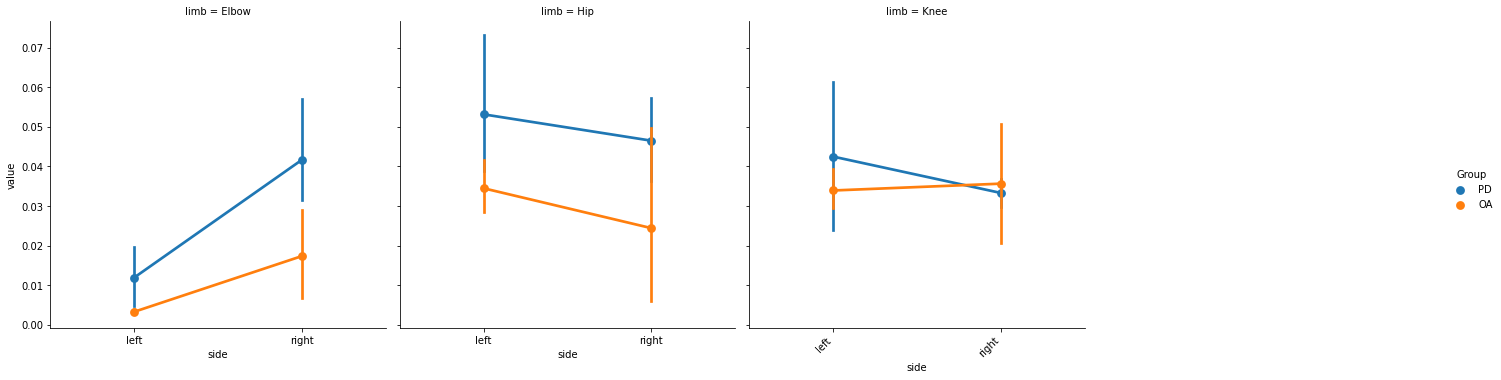

In [130]:
sns.catplot(data = plot_df, x = 'side', y = 'value', kind = 'point',
            col = 'limb', col_wrap = 4, hue = 'Group',
            margin_titles=True, sharex = False)
plt.xticks(rotation=45, horizontalalignment = 'right')

In [131]:
clean_melt['variable'].unique()

array(['SamEn_Elbow-LT-Flexion (deg)', 'SamEn_Elbow-RT-Flexion (deg)',
       'SamEn_Hip-LT-Abduction (deg)', 'SamEn_Hip-LT-Flexion (deg)',
       'SamEn_Hip-LT-Rotation Ext (deg)', 'SamEn_Hip-RT-Abduction (deg)',
       'SamEn_Hip-RT-Flexion (deg)', 'SamEn_Hip-RT-Rotation Ext (deg)',
       'SamEn_Knee-LT-Flexion (deg)', 'SamEn_Knee-RT-Flexion (deg)'],
      dtype=object)